Analysis of transactions data of one company in the period from 2005-2015. A certain number of transactions are fraudulent.

In [ ]:
# Import the necesarry libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as st
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from google.colab import drive

# Mount the dataset
drive.mount('/content/drive')
dataset = pd.read_excel('/content/drive/MyDrive/transactions_dataset.xlsx')
dataset.head()

Mounted at /content/drive


,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,transYear
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,2005
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,2006
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,2007
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,2011
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,2014


This dataset contains financial transaction records with details such as transaction type, amount, sender (nameOrig), receiver (nameDest), balances before and after the transaction, and whether the transaction was fraudulent (isFraud). The dataset also tracks transaction years (transYear), which can help analyze fraud trends over time.

In [ ]:
# Check if there are missing data fields in the dataset
missing_data = dataset.isnull().sum()
columns_with_missing_data = missing_data[missing_data > 0]

# Show result
if not columns_with_missing_data.empty:
    print("Columns with missing data:")
    print(columns_with_missing_data)
else:
    print("No missing data found in the dataset.")

No missing data found in the dataset.


isFraud can either be 0 or 1. Amount and year are of numerical value.

In [ ]:
# Find unique values in "type" column
unique_type = dataset['type'].unique()

# Show unique values
print("Unique values in the 'type' column:")
for i in unique_type:
    print(f"\t{i}")

Unique values in the 'type' column:
	PAYMENT
	TRANSFER
	CASH_OUT
	DEBIT
	CASH_IN


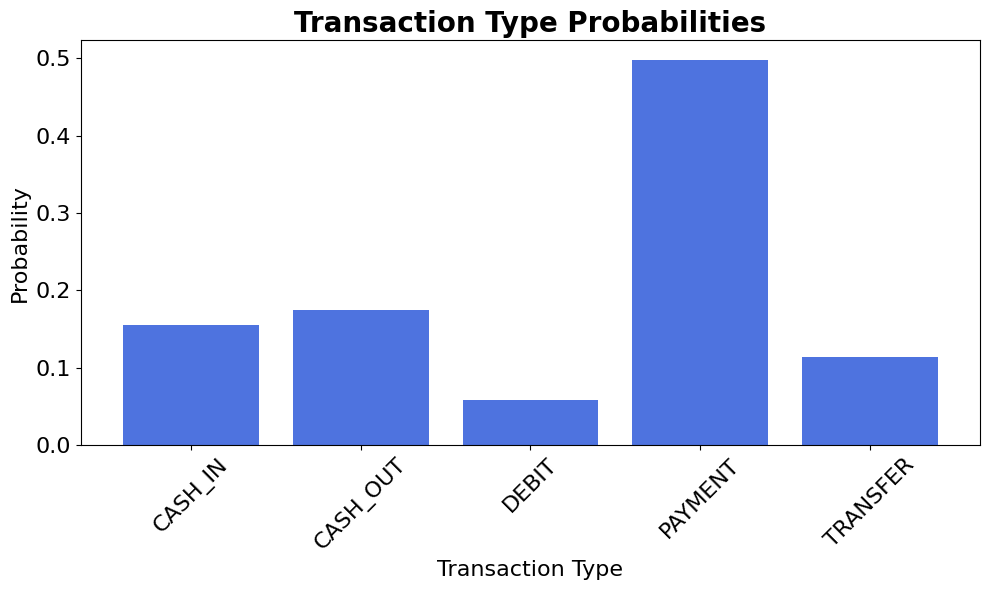

,Probability
CASH_IN,0.1555
CASH_OUT,0.1745
DEBIT,0.0580
PAYMENT,0.4985
TRANSFER,0.1135


In [ ]:
# Calculate the probability of each transactrion to fall into certain type category
typeAmount = dataset[["type", "amount"]]
data_temp = typeAmount["type"].value_counts().sort_index()
transType = pd.DataFrame((data_temp/data_temp.sum()))
transType.index = ["CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER"]
transType.columns = ["Probability"]

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot
transType.plot.bar(ax=ax, color='#4e73df', fontsize=16, legend=False, width=0.8)
ax.set_ylabel("Probability", fontsize=16)
ax.set_xlabel("Transaction Type", fontsize=16)
ax.set_title("Transaction Type Probabilities", fontsize=20, weight='bold')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Show plot
plt.show()

# Display the DataFrame
transType

Around 50% of all transactions are of PAYMENT type.

In [ ]:
# Calculate and display statistics of all amounts
print("Mean: {:.2f}".format(np.mean(typeAmount["amount"])))
print("Median: {:.2f}".format(np.median(typeAmount["amount"])))
print("Variance: {:.2f}".format(np.var(typeAmount["amount"])))
print("Standard Deviation: {:.2f}".format(np.std(typeAmount["amount"])))
print("Min. Value: {:.2f}".format(np.min(typeAmount["amount"])))
print("Max. Value: {:.2f}".format(np.max(typeAmount["amount"])))

Mean: 111110.87
Median: 10497.69
Variance: 67302315971.46
Standard Deviation: 259426.90
Min. Value: 8.73
Max. Value: 3776389.09


In [ ]:
# Fraud statistics (amount)
amountFraud = dataset[dataset["isFraud"] == 1][["amount"]]

# Print statistics
print(f"Mean: {np.mean(amountFraud['amount']):.2f}")
print(f"Median: {np.median(amountFraud['amount']):.2f}")
print(f"Variance: {np.var(amountFraud['amount']):.2f}")
print(f"Standard Deviation: {np.std(amountFraud['amount']):.2f}")
print(f"Min. Value: {np.min(amountFraud['amount']):.2f}")
print(f"Max. Value: {np.max(amountFraud['amount']):.2f}")

Mean: 115784.73
Median: 69713.85
Variance: 42321645718.12
Standard Deviation: 205722.25
Min. Value: 181.00
Max. Value: 1277212.77


Fraudulent transactions tend to involve larger amounts compared to non-fraudulent ones.
The right-skewed nature of general transactions suggests that while most transactions are relatively small, a few very large ones pull the mean up significantly.
High variance and standard deviation confirm a wide range of transaction sizes, both in general and fraudulent cases.

Based on this let's define 111110 usd or higher for high transactions.

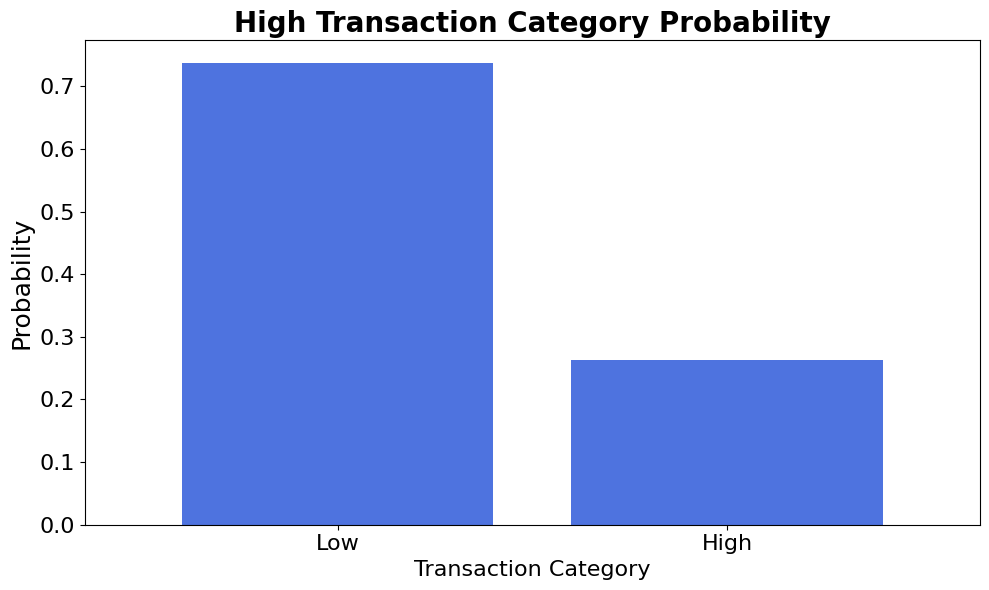

Probability,Probability
Low,0.7365
High,0.2635


In [ ]:
# Calculate the probability of a transaction to fall into the high category
highTrans = 111110
data_temp = (typeAmount["amount"] >= highTrans).value_counts()
df_highTrans = pd.DataFrame(data_temp/data_temp.sum())
df_highTrans.index = ["Low","High"]
df_highTrans.columns = ["Probability"]
df_highTrans.columns.name = "Probability"

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot
df_highTrans.plot.bar(ax=ax, color='#4e73df', fontsize=16, legend=False, width=0.8)

# Set the labels, title, and axis properties
ax.set_ylabel("Probability", fontsize=18)
ax.set_xlabel("Transaction Category", fontsize=16)
ax.set_title("High Transaction Category Probability", fontsize=20, weight='bold')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()

# Show plot
plt.show()

# Display the DataFrame
df_highTrans

In [ ]:
# Count the number of high-amount transactions by type
data_temp = typeAmount.loc[typeAmount["amount"]>highTrans,"type"].value_counts().sort_index()

# Show result
print(data_temp)

type
CASH_IN     173
CASH_OUT    191
TRANSFER    163
Name: count, dtype: int64


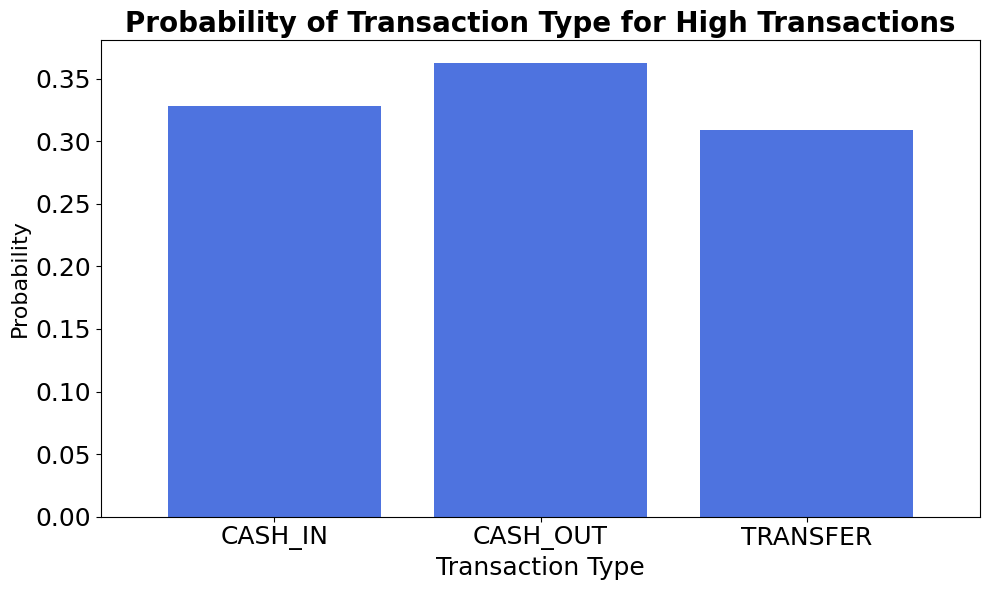

Transaction type,Probability
CASH_IN,0.328273
CASH_OUT,0.362429
TRANSFER,0.309298


In [ ]:
# Calculate the probability that if the transaction is high it will be of a certain type
df_highTransType = pd.DataFrame((data_temp/data_temp.sum()))
df_highTransType.index = ["CASH_IN", "CASH_OUT", "TRANSFER"]
df_highTransType.columns = ["Probability"]
df_highTransType.columns.name = "Transaction type"

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot
df_highTransType.plot.bar(ax=ax, color='#4e73df', fontsize=18, legend=False, width=0.8)

# Set the labels, title, and axis properties
ax.set_ylabel("Probability", fontsize=16)
ax.set_xlabel("Transaction Type", fontsize=18)
ax.set_title("Probability of Transaction Type for High Transactions", fontsize=20, weight='bold')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()

# Show plot
plt.show()

# Display the DataFrame
df_highTransType

None of the high transactions are of PAYMENT or DEBIT type.

In [ ]:
# Compare the probabilities of the types of transactions in the case of a high transaction in order to notice the differences
typeFraud = dataset[["type", "isFraud"]]
data_temp1 = typeFraud.loc[typeFraud["isFraud"] == 1, "type"].value_counts().sort_index()
data_temp1 = pd.DataFrame(data_temp1 / data_temp1.sum())
data_temp1.columns = ["Percentge of fraud transactions"]
highAndFraudTrans = transType.rename(columns={"Probability": "Percentage"})

# Merge with df_highTransType
highAndFraudTrans = highAndFraudTrans.join(df_highTransType["Probability"])
highAndFraudTrans = highAndFraudTrans.rename(columns={"Probability": "Percentge of high transactions"})

# Merge with data_temp1
highAndFraudTrans = highAndFraudTrans.merge(data_temp1, left_index=True, right_index=True, how="left")

# Set column names
highAndFraudTrans.columns.name = "Transaction type"

# Display result
print(highAndFraudTrans)

Transaction type  Percentage  Percentge of high transactions  \
CASH_IN               0.1555                        0.328273   
CASH_OUT              0.1745                        0.362429   
DEBIT                 0.0580                             NaN   
PAYMENT               0.4985                             NaN   
TRANSFER              0.1135                        0.309298   

Transaction type  Percentge of fraud transactions  
CASH_IN                                  0.554054  
CASH_OUT                                 0.364865  
DEBIT                                         NaN  
PAYMENT                                       NaN  
TRANSFER                                 0.081081  


Type PAYMENT dominates in all transactions, while it is not present at all in high transactions.

When it comes to fraudulent transactions, the situation is similar, there are no PAYMENT and DEBIT types at all.

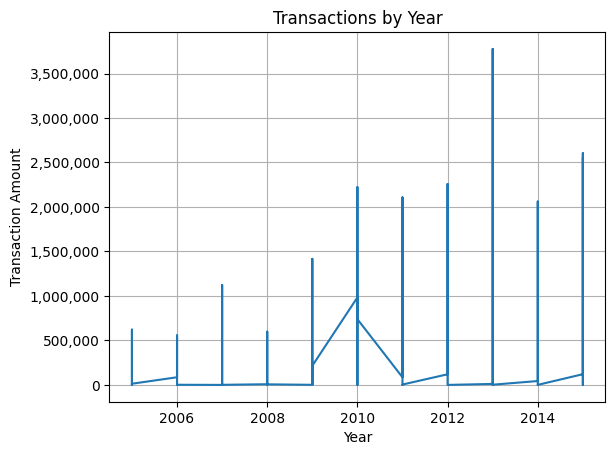

In [ ]:
# Calculate the amount of transactions by years
transPerYear = dataset[["transYear", "amount"]]
transPerYear = transPerYear.sort_values(by = ["transYear"])
x = transPerYear["transYear"]
y = transPerYear["amount"]

# Plot the data
plt.plot(x, y)

# Format the y-axis labels
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Transaction Amount')
plt.title('Transactions by Year')

# Add grid lines for better readability
plt.grid(True)

# Display the plot
plt.show()

The amount of transactions is increasing yearly. Applying linear regression can further confirm that the amount of the transaction increases with the increase of the year.

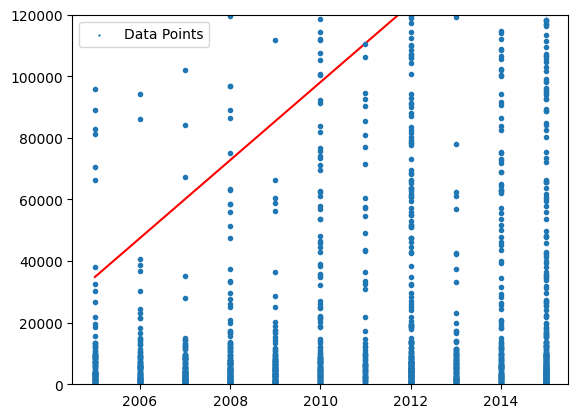

In [ ]:
# Linear regression

x = transPerYear["transYear"]
y = transPerYear["amount"]

# Construct the matrix for linear regression
M1 = np.vstack( (np.ones_like(x), x) ).T

# Perform linear least squares regression to find the optimal coefficients
p1 = np.linalg.lstsq(M1, y, rcond=None)
w1 = p1[0]

# Calculate the estimated y values (fitted line) based on the regression coefficients
y_est_lin = w1[0] + w1[1] * x

# Plot settings
plt.ylim(0, 120000)
plt.plot(x,y_est_lin, 'r-', x, y, '.')
plt.scatter(x = transPerYear["transYear"], y = transPerYear["amount"], s = 0.5, label='Data Points')

# Display the plot
plt.legend()
plt.show()

The data proves that the amount is indeed increasing yearly.

In [ ]:
# Calculate statistics
mean_value = np.mean(transPerYear["transYear"])
variance = np.var(transPerYear["transYear"])
std_dev = np.std(transPerYear["transYear"])
median_value = np.median(transPerYear["transYear"])
min_value = np.min(transPerYear["transYear"])
max_value = np.max(transPerYear["transYear"])

# Display results
print(f"Mean: {mean_value:.2f}")
print(f"Median: {median_value:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Min: {min_value}, Max: {max_value}")

Mean: 2011.03
Median: 2012.00
Variance: 9.97
Standard Deviation: 3.16
Min: 2005, Max: 2015


Variance measures how much the values deviate from the mean on average. Variance of 9.97 suggests a moderate level of spread.

Standard deviation shows how much, on average, each value deviates from the mean.

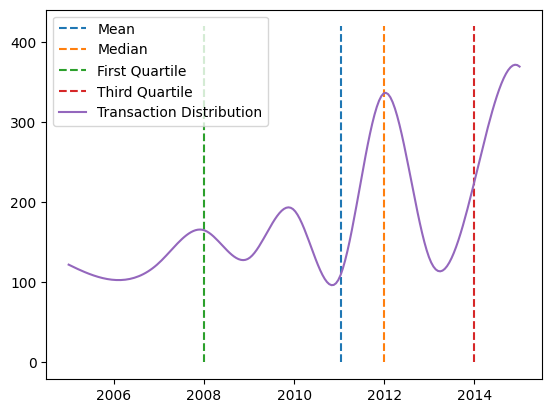

In [ ]:
# Sort the transaction amounts by years and calculate their mathematical expectation, median and quarters
transPerYear = transPerYear.sort_values("transYear")

# Get transaction counts per year
year_counts = transPerYear["transYear"].value_counts().sort_index()
years = np.arange(2005, 2016)
counts = [year_counts.get(year, 0) for year in years]

# Smooth the curve using cubic spline interpolation
xnew = np.linspace(min(years), max(years), 200)
spl = make_interp_spline(years, counts, k=3)
y_smooth = spl(xnew)

# Calculate statistical measures
xMean = np.mean(transPerYear["transYear"])
xMedian = np.median(transPerYear["transYear"])
firstQ = np.percentile(transPerYear["transYear"], 25)
fourthQ = np.percentile(transPerYear["transYear"], 75)

# Plot
plt.plot([xMean, xMean], [0, max(counts) + 50], label="Mean", linestyle="--")
plt.plot([xMedian, xMedian], [0, max(counts) + 50], label="Median", linestyle="--")
plt.plot([firstQ, firstQ], [0, max(counts) + 50], label="First Quartile", linestyle="--")
plt.plot([fourthQ, fourthQ], [0, max(counts) + 50], label="Third Quartile", linestyle="--")
plt.plot(xnew, y_smooth, label="Transaction Distribution")

# Display plot
plt.legend()
plt.show()

Let's see if with the increase in the amount of transactions fraud also increases.

Correlation Coefficient:
 [[1.         0.00353141]
 [0.00353141 1.        ]]


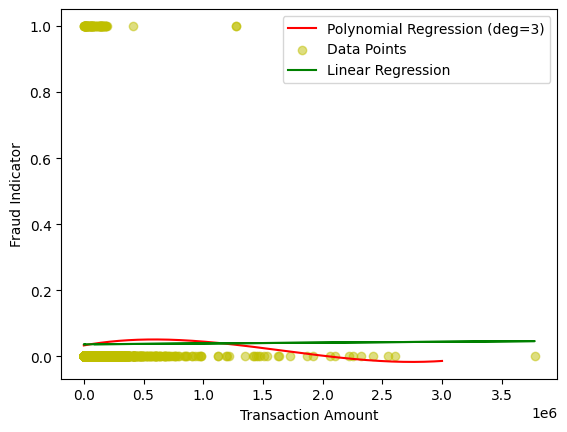

In [ ]:
# Calculate the correlation coefficient to see if the increase is positive, negative, or neutral

# Handle missing values efficiently
dataset["amount"] = dataset["amount"].fillna(0)

# Extract values
value = dataset["amount"].to_numpy()
fraud = dataset["isFraud"].to_numpy()

# Polynomial regression (degree 3)
poly_model = np.poly1d(np.polyfit(value, fraud, 3))
x_poly = np.linspace(0, 3_000_000, 500)
plt.plot(x_poly, poly_model(x_poly), c="r", label="Polynomial Regression (deg=3)")

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(value, fraud)
print("Correlation Coefficient:\n", correlation_matrix)

# Scatter plot of actual data points
plt.scatter(value, fraud, c="y", alpha=0.5, label="Data Points")

# Linear regression
X = np.column_stack((np.ones_like(value), value))
w, _, _, _ = np.linalg.lstsq(X, fraud, rcond=None)  # Least squares solution
y_linear = w[0] + w[1] * value
plt.plot(value, y_linear, c="g", label="Linear Regression")

# Plot settings
plt.xlabel("Transaction Amount")
plt.ylabel("Fraud Indicator")

# Display plot
plt.legend()
plt.show()

By correlation and linear regression, the larger the amount of the transaction, the greater the chance that it is a fraud. Polynomial regression also indicates the same, but up to a certain amount, which means that after that amount the claim ceases to be valid.

Total number of fraud transactions: 74 / 2000
       Percentage: 3.7%
Total value of fraud transactions: 8568069.67 / 222221735.23999998
       Percentage: 3.86%


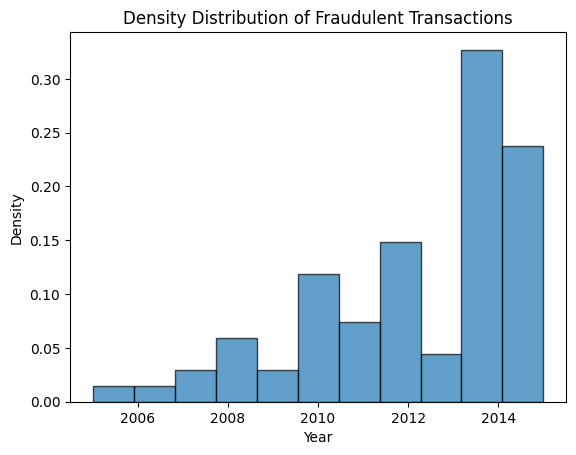

In [ ]:
# Make a histogram of the density distribution of fraudulent transactions, for a better overview

fraudPerYear = dataset.loc[dataset["isFraud"] == 1, "transYear"]

# Get fraud count per year
years = list(range(2005, 2016))
fraud_counts = fraudPerYear.value_counts().reindex(years, fill_value=0).sort_index()

# Calculate fraud statistics
total_fraud_count = fraud_counts.sum()
total_transactions = len(dataset)
total_fraud_value = dataset.loc[dataset["isFraud"] == 1, "amount"].sum()
total_transaction_value = dataset["amount"].sum()

# Print fraud statistics
print(f"Total number of fraud transactions: {total_fraud_count} / {total_transactions}")
print(f"       Percentage: {round((total_fraud_count / total_transactions) * 100, 2)}%")
print(f"Total value of fraud transactions: {total_fraud_value} / {total_transaction_value}")
print(f"       Percentage: {round((total_fraud_value / total_transaction_value) * 100, 2)}%")

# Plot histogram
plt.hist(years, weights=fraud_counts, density=True, bins=len(years), edgecolor='black', alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Density")
plt.title("Density Distribution of Fraudulent Transactions")

# Show histogram
plt.show()

Standard Error: 0.2974
Mean: 2012.39
Standard Deviation: 2.56
95% Confidence Interval: (np.float64(2011.7992702387846), np.float64(2012.9845135449991))


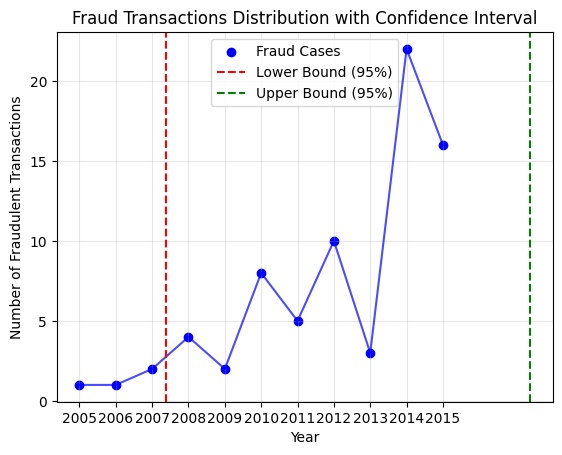

In [ ]:
# Calculate the standard erorr, standard deviation, confidence interval, and mean

# Ensure fraudPerYear remains a DataFrame
fraudPerYear = dataset[["isFraud", "transYear"]]

# Extract only fraud transaction years
fraud_years = fraudPerYear.loc[fraudPerYear["isFraud"] == 1, "transYear"]

# Calculate statistics
mean_x = np.mean(fraud_years)
std_x = np.std(fraud_years, ddof=1)  # Sample standard deviation
standard_error = std_x / np.sqrt(len(fraud_years))

# Confidence Interval (95%)
confidence = 0.95
conf_interval = st.t.interval(confidence, df=len(fraud_years)-1, loc=mean_x, scale=standard_error)

# 95% normal distribution confidence bounds
z = 1.960  # For 95% confidence
left_bound = mean_x - z * std_x
right_bound = mean_x + z * std_x

# Print results
print(f"Standard Error: {standard_error:.4f}")
print(f"Mean: {mean_x:.2f}")
print(f"Standard Deviation: {std_x:.2f}")
print(f"95% Confidence Interval: {conf_interval}")

# Prepare data for histogram or scatter
x_values = list(range(2005, 2016))  # Years 2005-2015
y_values = [fraud_years.tolist().count(year) for year in x_values]

# Use scatter instead of over-smoothed curve
plt.scatter(x_values, y_values, color="blue", label="Fraud Cases")
plt.plot(x_values, y_values, linestyle='-', color="blue", alpha=0.7)

# Confidence Interval Lines
plt.axvline(left_bound, color="red", linestyle="--", label="Lower Bound (95%)")
plt.axvline(right_bound, color="green", linestyle="--", label="Upper Bound (95%)")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Fraud Transactions Distribution with Confidence Interval")
plt.xticks(range(2005, 2016))
plt.legend()
plt.grid(alpha=0.3)

# Show plot
plt.show()

If we randomly select a fraudulent transaction, there is a 95% chance that it will be found between the orange and green lines.

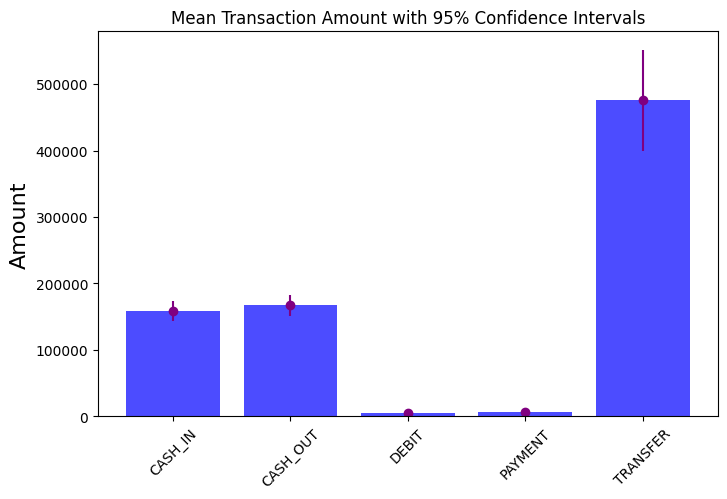

{'CASH_IN': (np.float64(144138.83768029898), np.float64(173832.08527790042)), 'CASH_OUT': (np.float64(150948.30974950653), np.float64(183089.8382734161)), 'DEBIT': (np.float64(4021.717747677277), np.float64(5149.221045426169)), 'PAYMENT': (np.float64(5734.098511991219), np.float64(6397.6906153909285)), 'TRANSFER': (np.float64(399154.7830577674), np.float64(551576.3936823207))}


In [ ]:
# Separate transactions by type and measuring their mean values
# On each type apply the interval estimation of the confidence parameter
# For this example let's put it to be 95% (alpha is 2.5% on each side)

# Confidence level
confidence = 0.95

# Group transactions by type and replacing NaN values with 0
grouped = dataset.groupby("type")["amount"].apply(lambda x: x.fillna(0).to_numpy())

# Calculate means and confidence intervals
stats = {
    t: {
        "mean": np.mean(values),
        "ci": st.t.interval(
            confidence=confidence,
            df=len(values)-1,
            loc=np.mean(values),
            scale=st.sem(values) if len(values) > 1 else 0  # Handle cases where len(values) == 1
        ),
    }
    for t, values in grouped.items()
}

# Plot
plt.figure(figsize=(8, 5))
transaction_types = list(stats.keys())
means = [stats[t]["mean"] for t in transaction_types]
cis = [stats[t]["ci"] for t in transaction_types]

plt.bar(transaction_types, means, color="blue", alpha=0.7)
for i, (low, high) in enumerate(cis):
    plt.errorbar(i, means[i], yerr=[[means[i] - low], [high - means[i]]], fmt='o', color="purple")

plt.ylabel("Amount", fontsize=16)
plt.title("Mean Transaction Amount with 95% Confidence Intervals")
plt.xticks(rotation=45)
plt.show()

# Print confidence intervals
print({t: stats[t]["ci"] for t in transaction_types})

The purple lines are not so big, which means that there is no big deviation from the mathematical expectation during random selection. Transactions with the largest amount of money are of the TRANSFER type.

Earlier, it was proved that the amount of transactions increases with year. Putting that fact into the multiple regression model, it is possible to predict what will happen to the number of fraudulent transactions.

In [ ]:
# Multiple regression

# Prepare dataset
mR = dataset[["amount", "transYear", "isFraud"]].copy()  # Ensure it's a separate copy
mR["amount"] = mR["amount"].fillna(0)  # Safe way to replace NaN values

# Define features (X) and target (y)
x = mR[["transYear", "amount"]]
y = mR["isFraud"]

# Train linear regression model
regr = LinearRegression()
regr.fit(x, y)

# Define test cases for fraud prediction
test_cases = pd.DataFrame({
    "transYear": [2005, 2005, 2005, 2015, 2015, 2015],
    "amount": [10000, 100000, 800000, 10000, 100000, 800000]
})

# Make predictions
predictions = regr.predict(test_cases)

# Print results
for year, amount, fraud_prob in zip(test_cases["transYear"], test_cases["amount"], predictions):
    print(f"The probability of fraud for a transaction in {year} with amount ${amount} is: {fraud_prob:.6f}")

The probability of fraud for a transaction in 2005 with amount $10000 is: 0.006713
The probability of fraud for a transaction in 2005 with amount $100000 is: 0.006078
The probability of fraud for a transaction in 2005 with amount $800000 is: 0.001135
The probability of fraud for a transaction in 2015 with amount $10000 is: 0.058116
The probability of fraud for a transaction in 2015 with amount $100000 is: 0.057480
The probability of fraud for a transaction in 2015 with amount $800000 is: 0.052537


With the increase of the year and the amount of the transaction, the chance of the transaction being a fraud increases, but up to a certain amount (as it was seen before), and then it decreases.